# Foundation of Deep Learning
Group Challenge

***
by: Oskar Girardin (B00792974), Lasse Schmidt (B00792989)

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [1]:
# import own scripts (reload from scratch every time this cell is run)
import util.preprocess_data as prepData
import util.load_data as loadData
import util.visualize_data as vizData

In [2]:
# parse & handle data
import os
import glob
import json
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image, ImageOps
import tarfile

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

# hyperparam optimization
from functools import partial
from ray import tune, air
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.experiment.trial import Trial

# pretrained models
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils

# evaluation metrics
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# visualization
import matplotlib.pyplot as plt
from tqdm import tqdm # Progress bar
from pprint import pprint
import tensorboardX # raytune results can be visualized using tensorboard!

### 2. Core Settings

In [2]:
av = 2

In [2]:
# directory of this notebook
notebook_path = ut.get_notebook_path()

# paths to (synthetic) pretraining data

# paths to original training & test data
X_path = notebook_path + "\\Hurricane_Harvey\\rasters\\raw\\"
y_path = notebook_path + "\\Hurricane_Harvey\\vectors\\random-split-_2022_11_17-22_35_45\\Masks\\"

# paths where we want to save sliced training data (test data will not be sliced!)
X_train_slice_path = notebook_path + "\\Hurricane_Harvey\\slices\\Images\\"
y_train_slice_path = notebook_path + "\\Hurricane_Harvey\\slices\\Masks\\"

# path where we want to save predictions
save_preds_val = notebook_path + "\\Hurricane_Harvey\\slices\\val_masks\\"
save_preds_test = notebook_path + "\\Hurricane_Harvey\\test_masks\\"

# path to provided metadata.json file
meta_path = notebook_path + "\\Hurricane_Harvey\\vectors\\random-split-_2022_11_17-22_35_45\CSV\metadata.json"

# path where RayTune results should be saved
ray_path = notebook_path + "\\ray_results\\"

# initialise our DataGetter class that does the heavy lifting for us
DataGetter = ut.DataGetter()

### 3. Retrieve Data

In [3]:
# get paths to training & test data
X_train_paths, y_train_paths, X_test_paths = DataGetter.get_train_test_doc_paths(X_path, y_path)

In [4]:
# slice training data
N = 6 # number of images we want to generate from each original image (12 was a bit too high)
X_train_paths = DataGetter.slice_images(X_train_paths, X_train_slice_path, N)
y_train_paths = DataGetter.slice_images(y_train_paths, y_train_slice_path, N)

D:\Dokumente\2_Bildung\2_MSc\1_Classes\Foundations of Deep Learning\5_group project\Hurricane_Harvey\slices\Images\ already contains 1794 files!
Data will only be sliced after manually deleting the existing files in save_dir and re-running this function! Otherwise who knows what data you will be training on!

D:\Dokumente\2_Bildung\2_MSc\1_Classes\Foundations of Deep Learning\5_group project\Hurricane_Harvey\slices\Masks\ already contains 1794 files!
Data will only be sliced after manually deleting the existing files in save_dir and re-running this function! Otherwise who knows what data you will be training on!



In [2]:
# settings of transformations
TRAIN_HEIGHT, TRAIN_WIDTH = 320, 256
TEST_HEIGHT, TEST_WIDTH = 864, 1152 # 1152, 1536
MEANS = [0.43848444476627263, 0.4619797747350208, 0.3890778756853456]
STDS = [0.21185429222980653, 0.1954314059495751, 0.21883507528280788]

# define transforms that we will be using
transform_train = A.Compose(
    [
        #A.PadIfNeeded(min_height = TRAIN_HEIGHT, min_width = TRAIN_WIDTH),
        #A.RandomCrop(TRAIN_HEIGHT, TRAIN_WIDTH), # resize & keep 4:3 format (increase for better performance, if possible)
        A.Resize(TRAIN_HEIGHT, TRAIN_WIDTH),
        #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit = 0.1, p=0.5), # randomly change brightness and contrast of the input image
        A.CLAHE(clip_limit = 2.0, p = 1), # always apply Contrast Limited Adaptive Histogram Equalization
        A.Sharpen(p = 1), # always sharpen the image
        A.Normalize(mean=MEANS, std=STDS), # only applied to image (not the mask!)
        ToTensorV2()
    ]
)

transform_test = A.Compose(
    [
        A.Resize(TEST_HEIGHT, TEST_WIDTH), # scale down image (keep this as large as possible for best predictions)
        A.CLAHE(clip_limit = 2.0, p = 1), # always apply Contrast Limited Adaptive Histogram Equalization
        A.Sharpen(p = 1), # always sharpen the image
        A.Normalize(mean = MEANS, std = STDS),
        ToTensorV2()
    ]
)

# transforms without normalize & tensor conversion for easy visualization of what we do
transform_train_visualize = A.Compose(transform_train[:-2])
transform_test_visualize = A.Compose(transform_test[:-2])

In [6]:
# get datasets
trainset, valset, testset = DataGetter.get_datasets(X_train_paths, y_train_paths, X_test_paths,
                                                    transform_train, transform_test)

# get class dict
class_dict = DataGetter.get_class_dict(meta_path)

# show sizes of datasets
print(f"Size of training data: {trainset.__len__()}")
print(f"Size of validation data: {valset.__len__()}")
print(f"Size of test data: {testset.__len__()} \n")

Size of training data: 1615
Size of validation data: 179
Size of test data: 75 



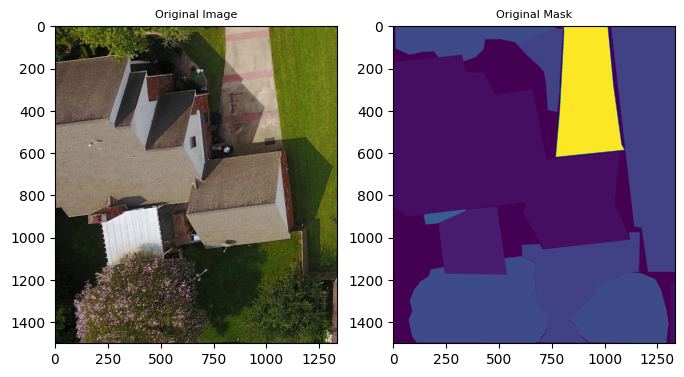

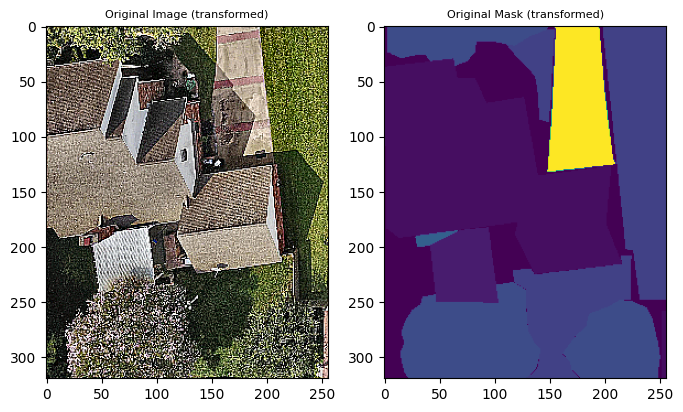

In [7]:
# fetch random image & mask for visualization
idx = 7
key = list(X_train_paths.keys())[idx]

# print raw output (without transformations)
raw_img = Image.open(X_train_paths[key])
raw_mask = Image.open(y_train_paths[key])
ut.visualize(raw_img, raw_mask)

# print transformed output
ut.visualize(raw_img, raw_mask, transform = transform_train_visualize)

In [8]:
# compute training mean & std of each channel (MUST match normalization values in defined transforms)
# MEANS, STDS = raw_trainset.compute_mean_std(indices = trainset.indices) # takes a minute to run!
print(f"means of training data: {MEANS}")
print(f"stds of training data: {STDS}")

means of training data: [0.43848444476627263, 0.4619797747350208, 0.3890778756853456]
stds of training data: [0.21185429222980653, 0.1954314059495751, 0.21883507528280788]


In [14]:
# train the model ("efficientnet-b2" only for batch size 2, efficientnet-b3 always out of memory)
config = {
    # variable passing
    "trainset": trainset,
    "valset": valset,
    "testset": testset,
    "class_dict": class_dict,
    "num_workers": 4,
    "max_epochs": 2,
    "criterion": criterion,
    
    # tunable hyperparams
    "model": tune.choice(["UNet"]), # "UNet", "Linknet", "FPN", "PSPNET"
    "encoder": tune.choice(["resnet18", "vgg16"]), # "resnet18", "vgg13", "vgg16"
    "batch_size": tune.choice([16, 32]),
    "lr": tune.choice([5e-5, 1e-4, 1e-3]), # 5e-5 too low for cosine
    "lr_scheduler": tune.choice(["Cosine", "OneCycle"]) #"Cyclic"
}
criterion = nn.CrossEntropyLoss()

ModelPipeline = ut.ModelPipeline(trainset, valset, testset, class_dict,
                                 num_workers = 4, max_epochs = 2, criterion = criterion)

In [20]:
# migrate to ray.tune.tuner instead of tune.run
def trial_str_creator(trial):
    return "{}".format(trial.trial_id)

scheduler = ASHAScheduler(
    time_attr = "training_iteration",
    metric = "loss",
    mode = "min",
    max_t = ModelPipeline.max_epochs,
    grace_period = 1, #10
    reduction_factor = 2)

reporter = JupyterNotebookReporter(
    metric_columns=["loss", "max_val_acc", "training_iteration"],
    parameter_columns=["model", "encoder", "batch_size", "lr", "lr_scheduler"],
    max_column_length = 10,
    max_progress_rows = 30,
    max_report_frequency = 10, # refresh output table every 10 seconds 
    print_intermediate_tables = True,
    metric = "val_accuracy",
    mode = "min")

tuner = tune.tuner(
    tune.with_resources(
        tune.with_parameters(ModelPipeline.train_model),
        resources={"cpu": 16, "gpu": 1}
    ),
    tune_config = tune.TuneConfig(
        metric = "loss",
        mode = "min",
        scheduler = scheduler,
        num_samples = 1,
        trial_name_creator = trial_str_creator,
        trial_dirname_creator = trial_str_creator,
        ),
    run_config = air.RunConfig(
        #name = exp_name,
        local_dir = ray_path,
        progress_reporter = reporter,
        verbose = 1),
    param_space = config
)    

tuner.fit()

TypeError: 'module' object is not callable

In [ ]:
# train the model ("efficientnet-b2" only for batch size 2, efficientnet-b3 always out of memory)
config = {
    "model": tune.choice(["UNet"]), # "UNet", "Linknet", "FPN", "PSPNET"
    "encoder": tune.choice(["resnet18", "vgg16"]), # "resnet18", "vgg13", "vgg16"
    "batch_size": tune.choice([16, 32]),
    "lr": tune.choice([5e-5, 1e-4, 1e-3]), # 5e-5 too low for cosine
    "lr_scheduler": tune.choice(["Cosine", "OneCycle"]) #"Cyclic"
}
criterion = nn.CrossEntropyLoss()

ModelPipeline = ut.ModelPipeline(trainset, valset, testset, class_dict,
                                 num_workers = 4, max_epochs = 2, criterion = criterion)

In [31]:
def trial_str_creator(trial):
    return "{}".format(trial.trial_id)

scheduler = ASHAScheduler(
    time_attr = "training_iteration",
    metric = "loss",
    mode = "min",
    max_t = ModelPipeline.max_epochs,
    grace_period = 10,
    reduction_factor = 2)

reporter = JupyterNotebookReporter(
    metric_columns=["loss", "max_val_acc", "training_iteration"],
    parameter_columns=["model", "encoder", "batch_size", "lr", "lr_scheduler"],
    max_column_length = 10,
    max_progress_rows = 30,
    max_report_frequency = 10, # refresh output table every 10 seconds 
    print_intermediate_tables = True,
    metric = "val_accuracy",
    mode = "min")

results = tune.run(
    partial(ModelPipeline.train_model),
    resources_per_trial={"cpu": 16, "gpu": 1},
    config = config,
    num_samples = 15,
    scheduler = scheduler,
    progress_reporter = reporter,
    local_dir = ray_path,
    trial_name_creator = trial_str_creator,
    trial_dirname_creator = trial_str_creator,
    verbose = 1)

best_trial = results.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["val_acc"]))

2023-01-12 23:44:56,222	ERROR trial_runner.py:1088 -- Trial ed388_00006: Error processing event.
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFunc.train() (pid=5696, ip=127.0.0.1, repr=func)
  File "python\ray\_raylet.pyx", line 830, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 834, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 780, in ray._raylet.execute_task.function_executor
  File "C:\Users\lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\_private\function_manager.py", line 674, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "C:\Users\lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\util\tracing\tracing_helper.py", line 466, in _resume_span
    return method(self, *_args, **_kwargs)
  File "C:\Users\lasse\AppData\Local\Programs\Python\Python310\lib\site-packages\ray\tune\trainable\trainable.py", line 367, in train
    raise skipped from exception_cause(skip

TuneError: ('Trials did not complete', [ed388_00006, ed388_00008])

#### Analyze a RayTune Experiment

In [23]:
experiment_path = ray_path + "train_model_2023-01-12_20-52-13\\"

In [24]:
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path)
result_grid = restored_tuner.get_results()

Loading results from D:\Dokumente\2_Bildung\2_MSc\1_Classes\Foundations of Deep Learning\5_group project\ray_results\train_model_2023-01-12_20-52-13\...


RuntimeError: Could not find Tuner state in restore directory. Did you passthe correct path (including experiment directory?) Got: D:\Dokumente\2_Bildung\2_MSc\1_Classes\Foundations of Deep Learning\5_group project\ray_results\train_model_2023-01-12_20-52-13\

In [3]:
logdir = notebook_path + "\\ray_results\\train_model_2023-01-12_21-23-07\\"

In [6]:
% tensorboard --inspect --event_file=~/ray_results/

UsageError: Line magic function `%` not found.


In [34]:
tensorboard --logdir=logdir

Reusing TensorBoard on port 6006 (pid 16908), started 0:02:12 ago. (Use '!kill 16908' to kill it.)

In [26]:
%tensorboard --logdir=~/ray_results/train_model_2023-01-12_21-23-07

In [16]:
results.fetch_trial_dataframes()[list(results.fetch_trial_dataframes().keys())[4]]

,loss,trn_acc,val_acc,max_val_acc,cur_lr,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,...,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time
0,2.832962,0.512195,0.596811,0.596811,0.00036,57.214767,False,NaN,NaN,1,...,2023-01-12_19-24-25,1673547865,57.214767,27696,Schenker-Media-Station,127.0.0.1,57.214767,0,1,0.003554
1,2.750568,0.630290,0.621892,0.621892,0.00036,54.209692,False,NaN,NaN,2,...,2023-01-12_19-25-19,1673547919,111.424459,27696,Schenker-Media-Station,127.0.0.1,111.424459,0,2,0.003554
2,2.689792,0.653983,0.669343,0.669343,0.00036,53.832660,False,NaN,NaN,3,...,2023-01-12_19-26-13,1673547973,165.257119,27696,Schenker-Media-Station,127.0.0.1,165.257119,0,3,0.003554
3,2.690027,0.673569,0.675128,0.675128,0.00036,53.574295,False,NaN,NaN,4,...,2023-01-12_19-27-06,1673548026,218.831414,27696,Schenker-Media-Station,127.0.0.1,218.831414,0,4,0.003554
4,2.668353,0.695592,0.693074,0.693074,0.00036,54.624693,False,NaN,NaN,5,...,2023-01-12_19-28-01,1673548081,273.456107,27696,Schenker-Media-Station,127.0.0.1,273.456107,0,5,0.003554
5,2.664027,0.702763,0.695551,0.695551,0.00036,54.154254,False,NaN,NaN,6,...,2023-01-12_19-28-55,1673548135,327.610361,27696,Schenker-Media-Station,127.0.0.1,327.610361,0,6,0.003554
6,2.669251,0.705505,0.690065,0.695551,0.00036,53.507781,False,NaN,NaN,7,...,2023-01-12_19-29-49,1673548189,381.118142,27696,Schenker-Media-Station,127.0.0.1,381.118142,0,7,0.003554
7,2.664732,0.710498,0.693895,0.695551,0.00036,53.450984,False,NaN,NaN,8,...,2023-01-12_19-30-42,1673548242,434.569125,27696,Schenker-Media-Station,127.0.0.1,434.569125,0,8,0.003554
8,2.656696,0.723070,0.701973,0.701973,0.00036,53.878996,False,NaN,NaN,9,...,2023-01-12_19-31-36,1673548296,488.448121,27696,Schenker-Media-Station,127.0.0.1,488.448121,0,9,0.003554
9,2.658374,0.729684,0.699913,0.701973,0.00036,53.314172,False,NaN,NaN,10,...,2023-01-12_19-32-29,1673548349,541.762293,27696,Schenker-Media-Station,127.0.0.1,541.762293,0,10,0.003554


### 5. Predictions of best model on validation data

In [10]:
## load best model
import os
path = os.path.abspath("")+"\\Models\\best-model.pt"
best_model = smp.Unet(encoder_name = "vgg16", classes = len(class_dict), activation = "softmax2d")

best_model.load_state_dict(torch.load(path))
best_model = best_model

In [11]:
## get paths to validation images
X_val_keys_array = np.array(list(valset.dataset.img_paths.keys()))[valset.indices]
X_val_paths_array = np.array(list(valset.dataset.img_paths.values()))[valset.indices]

X_val_paths = {}
for key, path in zip(X_val_keys_array, X_val_paths_array):
    X_val_paths[key] = path

## get paths to validation masks
y_val_keys_array = np.array(list(valset.dataset.mask_paths.keys()))[valset.indices]
y_val_paths_array = np.array(list(valset.dataset.mask_paths.values()))[valset.indices]

y_val_paths = {}
for key, path in zip(y_val_keys_array, y_val_paths_array):
    y_val_paths[key] = path

In [12]:
y_val_paths_pred = ModelPipeline.predict(best_model, ModelPipeline.valset, save_preds_val, test = False)

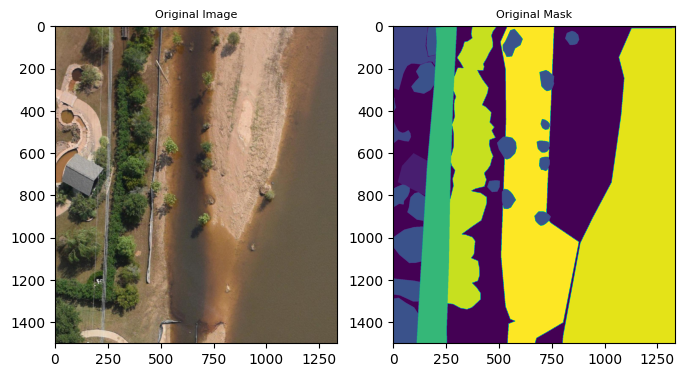

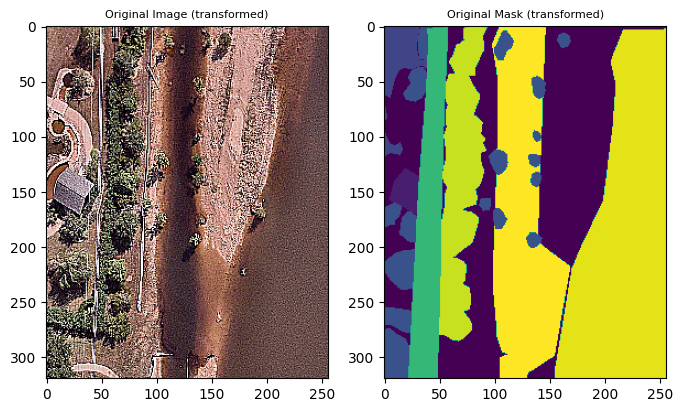

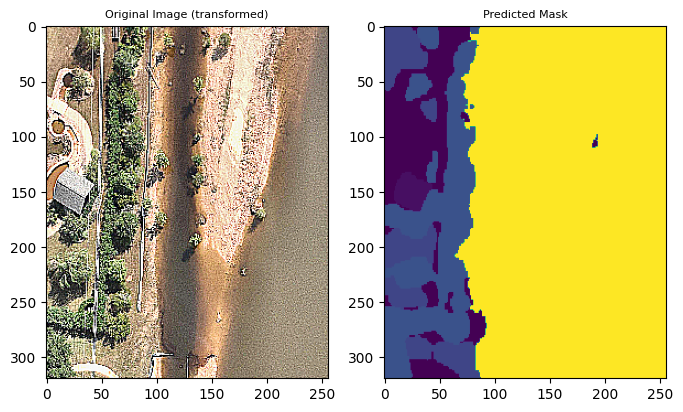

In [20]:
# fetch random validation image & its original mask and its predicted mask for visualization
idx = 12
key = list(X_val_paths.keys())[idx]

# print raw output (without transformations)
img = Image.open(X_val_paths[key])
mask = Image.open(y_val_paths[key])
pred_mask = Image.open(y_val_paths_pred[key])
ut.visualize(img, mask)
ut.visualize(img, mask, transform_train_visualize)
ut.visualize(img, pred_mask, transform_train_visualize, pred = True)

### 6. Predictions of best model on test data

In [18]:
## predict on test data
y_test_paths = ModelPipeline.predict(best_model, ModelPipeline.testset, save_preds_test)

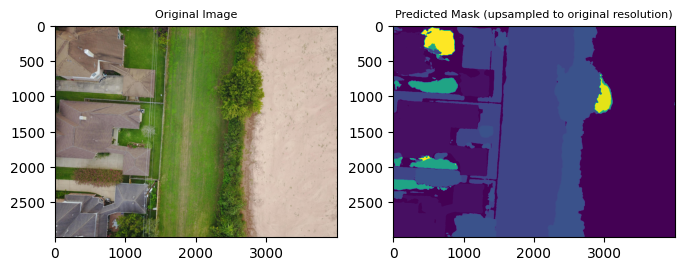

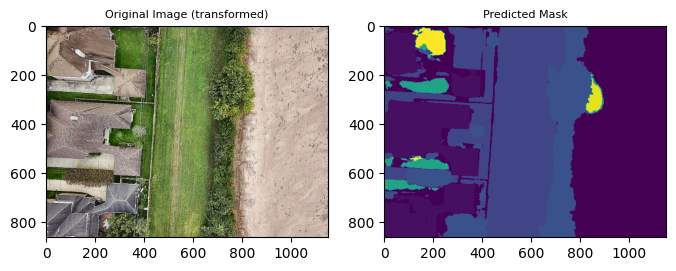

In [19]:
# fetch random test image & prediction mask for visualization
idx = 1
key = list(X_test_paths.keys())[idx]

# print raw output (without transformations)
test_img = Image.open(X_test_paths[key])
pred_mask = Image.open(y_test_paths[key])
ut.visualize(test_img, pred_mask, pred = True)
ut.visualize(test_img, pred_mask, transform_test_visualize, pred = True)

In [14]:
# create submission file
tar = tarfile.open("submission.tar", "w")
for (root, dirs, files) in os.walk(save_dir):
    for file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)
tar.close()

### X. Code Graveyard
too sad to delete, maybe keep for later

In [12]:
## create test prediction function
def make_preds(model, test_dataloader, save_dir):
    model.eval()
    names = []

    for i, batch in enumerate(test_dataloader):
        img_batch, names_batch = batch
        img_batch = img_batch.to(device)

        # compute predictions
        output = model(img_batch)
        
        # save predictions as masks
        with torch.no_grad():
            preds = torch.argmax(F.softmax(output.to(device), dim=1), dim=1)
            for name, pred in zip(names_batch, preds):
                img = Image.fromarray(pred.cpu().numpy().astype(np.uint8)) # convert Image data to PIL format
                size = test_dataloader.dataset.shapes[name] # fetch original shape of image
                img = img.resize(size = size, resample = Image.Resampling.NEAREST) # resize mask to size of original image
                path = save_dir + name + ".png" # where we want to save the image
                img.save(path, format = "PNG") # save image
                
make_preds(best_model, test_dataloader, save_dir)

#### Model Training (OLD)

Take pre-trained UNet model as first iteration (pretrained "resnet18" --> higher numbers still work, but push GPU to memory limit)

In [5]:
# get dataloaders
BATCH_SIZE_TRAIN_VAL = 8 # find best trade-off between batch_size and image_size that runs within GPU memory limits
BATCH_SIZE_TEST = 1 # test batch size doesn't change anything as we only predict
NUM_WORKERS = 4 # optimized this number for my local computer based on http://www.feeny.org/finding-the-ideal-num_workers-for-pytorch-dataloaders/

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE_TRAIN_VAL,
                                               num_workers = NUM_WORKERS, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size = BATCH_SIZE_TRAIN_VAL,
                                             num_workers = NUM_WORKERS, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE_TEST,
                                              num_workers = NUM_WORKERS, shuffle = True)

In [7]:
## clear cuda memory if necessary
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [8]:
## Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

## Initialise model
model = smp.Unet(encoder_name = "resnet18", classes = len(class_dict), activation = None).to(device)

## Set parameters for training
lr = 1e-4
optimizer = torch.optim.Adam([dict(params = model.parameters(), lr=lr)])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", factor = 0.1, patience = 2, min_lr = 1e-7, verbose = True)
criterion = smp_utils.losses.CrossEntropyLoss()
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]
epochs = 20

Device used: cuda


In [9]:
def get_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output,dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def training_loop(model, epochs, train_dataloader, val_dataloader, optimizer, criterion, device):
        
    total_trn_losses = []
    total_val_losses = []
    trn_accs = []
    val_accs = []
    max_val_acc = 0

    for epoch in range(1,epochs+1):
        print(f'epoch: {epoch}')
        ##TRAINING##
        model.train()
        trn_losses = []
        accuracy, batch_count = 0, 0
        
        for i, batch, in enumerate(tqdm(train_dataloader)):
            batch_count += 1
            img_batch, mask_batch = batch
            mask_batch = mask_batch.type(torch.LongTensor)
            img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
            
            # compute predictions
            optimizer.zero_grad()
            output = model(img_batch)
            
            # compute loss
            loss = criterion(output.float().to(device), mask_batch)
            trn_losses.append(loss.item())
            
            # compute evaluation metric
            accuracy += get_accuracy(output.float().to(device), mask_batch)
            
            # next step
            loss.backward()
            optimizer.step()
            
        trn_acc = accuracy / batch_count
        trn_loss_mean = np.mean(trn_losses)
        total_trn_losses.append(trn_loss_mean)

        ##VALIDATION##
        model.eval()
        val_losses = []
        accuracy, batch_count = 0, 0
        
        with torch.no_grad():

            for i, batch, in enumerate(tqdm(val_dataloader)):
                batch_count += 1
                img_batch, mask_batch = batch
                mask_batch = mask_batch.type(torch.LongTensor)
                img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
                
                # compute predictions
                output = model(img_batch)
                
                # compute loss
                loss = criterion(output.float().to(device), mask_batch)
                val_losses.append(loss.item())
                
                # compute evaluation metric
                accuracy += get_accuracy(output.float().to(device), mask_batch)

        val_acc = accuracy / batch_count
        val_loss_mean = np.mean(val_losses)
        total_val_losses.append(val_loss_mean)
        
        ##Save Model if it's the best performing model so far##
        if val_acc > max_val_acc:
            path = os.path.abspath("")+"\\Models\\best-model.pt"
            torch.save(model.state_dict(), path)
        
        ##Save Metrics for own analysis##
        print(f"Train accuracy: {round(trn_acc, 3)}")
        print(f"Val accuracy: {round(val_acc, 3)}\n")
        trn_accs.append(trn_acc)
        val_accs.append(val_acc)
        
        ##adapt learning rate##
        scheduler.step(val_loss_mean)
    
    return model, trn_accs, val_accs

In [10]:
# begin training
trained_model, trn_accs, val_accs = training_loop(model, epochs, train_dataloader,
                                                  val_dataloader, optimizer, criterion, device)

epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.39s/it]


Train accuracy: 0.124
Val accuracy: 0.295

epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.35s/it]


Train accuracy: 0.352
Val accuracy: 0.362

epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.36s/it]


Train accuracy: 0.416
Val accuracy: 0.554

epoch: 4


 44%|████████████████████████████████████▏                                             | 15/34 [00:17<00:22,  1.18s/it]


KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

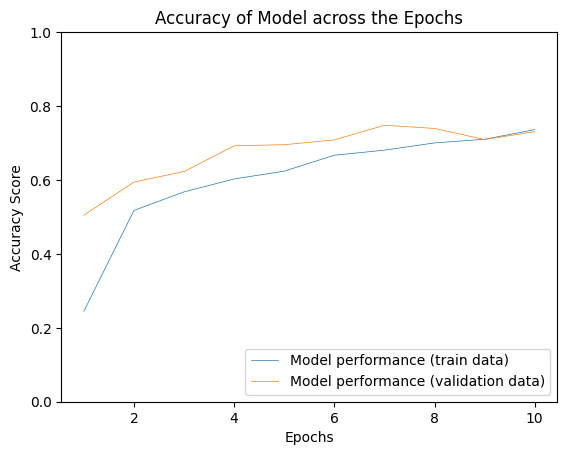

In [12]:
# plot train vs validation accuracy
x = range(1, epochs+1)
plt.plot(x, trn_accs, linewidth = 0.5, label = "Model performance (train data)")
plt.plot(x, val_accs, linewidth = 0.5, label = "Model performance (validation data)")
plt.title("Accuracy of Model across the Epochs")
plt.ylim(0, 1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.legend(loc="lower right")
plt.show

#### Model Training (even OLDER)

In [9]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [10]:
max_score = 0

for i in range(0, 3):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_dataloader)
    valid_logs = valid_epoch.run(val_dataloader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|                                                                                    | 0/30 [00:03<?, ?it/s]


RuntimeError: The size of tensor a (8) must match the size of tensor b (27) at non-singleton dimension 1

##### HERE I USED THE CustomTensorDataset Class defined in ut!

Here the whole dataset must be loaded into memory (only works for smaller resolutions and rather inefficient!).

In [ ]:
# get training data as numpy ndarray
train_shapes, X_train = ut.get_data_as_np_array(X_train_paths, SHAPE)
y_train = ut.get_data_as_np_array(y_train_paths, SHAPE, return_shapes = False)

# get test data as numpy ndarray
test_shapes, X_test = ut.get_data_as_np_array(X_test_paths, SHAPE)

# transform numpy ndarrays into tensors
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)

In [ ]:
# create training + validation pytorch datasets & dataloaders
raw_trainset = ut.CustomTensorDataset(tensors = (X_train, y_train))

trainset, valset = torch.utils.data.random_split(raw_trainset, [TRN_SIZE, VAL_SIZE])
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size = BATCH_SIZE, shuffle = True)

# create test pytorch dataset & dataloader
testset = ut.CustomTensorDataset(tensors = (X_test), targets = False) # test data has no targets
test_dataloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True)

# validate previous lines
print(f"Size of training data: {trainset.__len__()}")
print(f"Size of validation data: {valset.__len__()}")
print(f"Size of test data: {testset.__len__()} \n")

# compute descriptive statistics of training data
means = trainset.dataset.tensors[0][trainset.indices].mean(axis=(0,1,2))/255
stds = trainset.dataset.tensors[0][trainset.indices].std(axis=(0,1,2))/255
print(f"Shape of queried training data (must be {TRN_SIZE}, otherwise false): {trainset.dataset.tensors[0][trainset.indices].shape}")
print(means)
print(stds)